<a href="https://colab.research.google.com/github/cardavid11/tensorflow_certification/blob/main/tensorflow_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10,7]

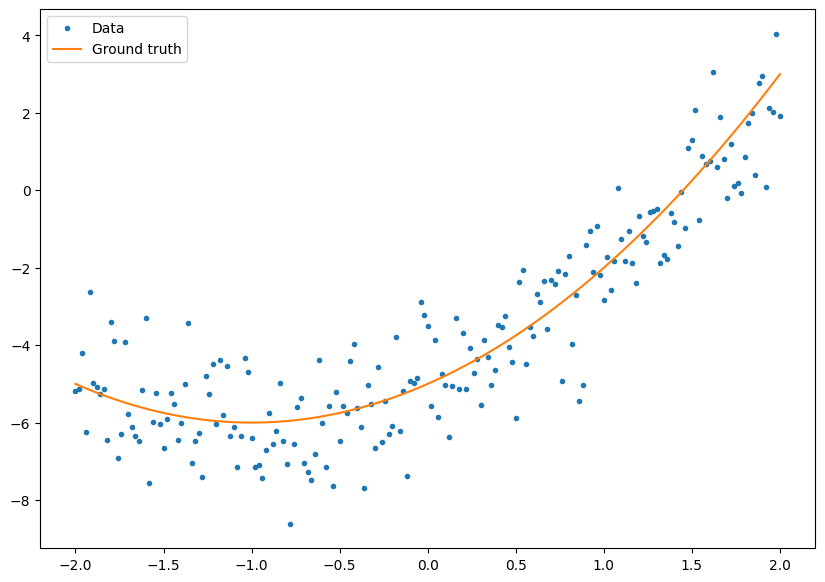

In [2]:
import tensorflow as tf
x = tf.linspace(-2,2,201) # Generates evenly-spaced values in an interval along a given axis. | tf.linspace(start, stop, num, name=None, axis=0)
x = tf.cast(x, tf.float32) # Casts a tensor to a new type. | tf.cast( x, dtype, name=None )

def f(x):
  y = x**2 + 2*x -5
  return y

y = f(x) + tf.random.normal(shape=[201]) # Outputs random values from a normal distribution. | tf.random.normal(shape,mean=0.0,stddev=1.0,dtype=tf.dtypes.float32,seed=None,name=None)
plt.plot(x.numpy(),y.numpy(),'.', label='Data') # .numpy() method is pretty much straightforward. It converts a tensor object into an numpy.ndarray object
plt.plot(x, f(x), label='Ground truth') # Ground truth is information that is known to be real or true, provided by direct observation and measurement (i.e. empirical evidence) as opposed to information provided by inference.
plt.legend();

In [3]:
# Create a quadratic model with randomly initialized weights and a bias:
class Model(tf.Module):
  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

In [4]:
quad_model = Model()

In [5]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

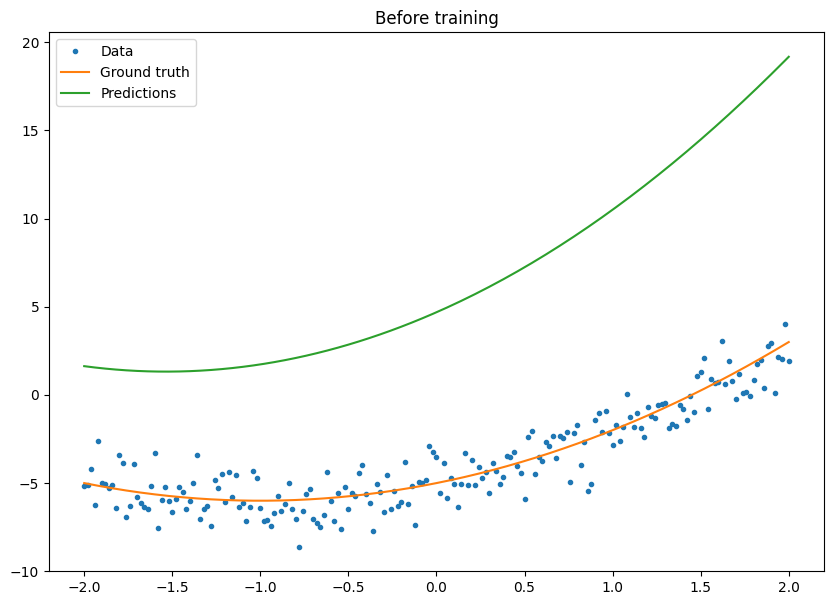

In [6]:
plot_preds(x, y, f, quad_model, 'Before training')

In [7]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

In [8]:
# The loop will make use of the MSE loss function and its gradients with respect to the
# input in order to iteratively update the model's parameters. Using mini-batches
# for training provides both memory efficiency and faster convergence.
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y)) # TensorSliceDataset Creates a dataset that emits each dim-0 slice of `components` once.
# dataset
# [x for x in dataset]

# Difference between Dataset.from_tensors and Dataset.from_tensor_slices
# from_tensors – This method is used to combine several smaller datasets to form a large dataset.
# from_tensor_slices – This method is generally used while training machine learning models using data input pipeline. This methods help us to combine the independent features and their target as one dataset.

In [9]:
dataset = dataset.shuffle(buffer_size=x.shape[0]) # Randomly shuffles the elements of this dataset. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
# [x for x in dataset]

In [10]:
dataset = dataset.batch(batch_size)
# [x for x in dataset]
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Look for information about this | Is not in the guide

Mean squared error for step 0: 59.021
Mean squared error for step 10: 9.999
Mean squared error for step 20: 4.181
Mean squared error for step 30: 2.201
Mean squared error for step 40: 1.486
Mean squared error for step 50: 1.238
Mean squared error for step 60: 1.150
Mean squared error for step 70: 1.120
Mean squared error for step 80: 1.111
Mean squared error for step 90: 1.105




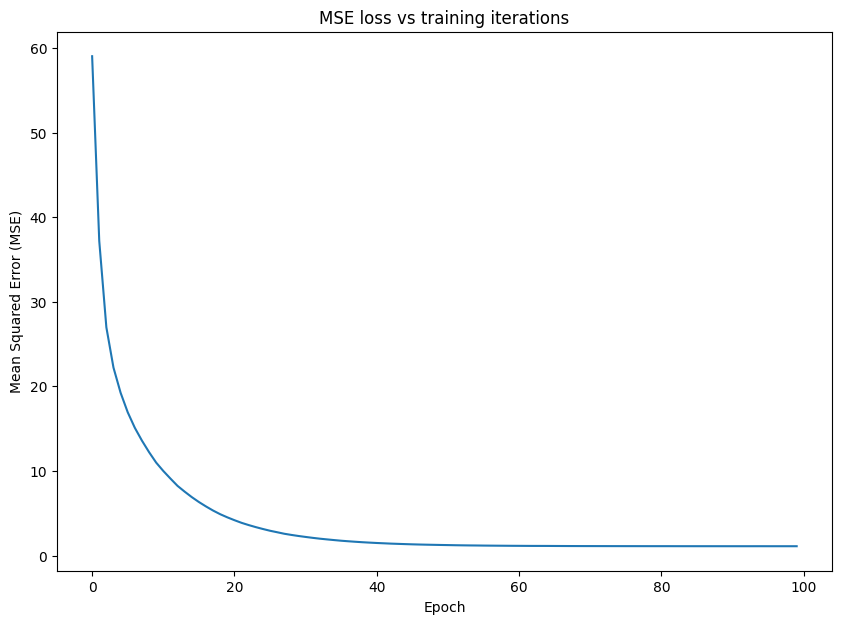

In [11]:
# Set training parameters
epochs = 100 # epochs: The number of times the training loop will run over the entire dataset.
learning_rate = 0.01 # learning_rate: The step size used for gradient descent optimization.
losses = [] # losses: A list to keep track of the loss at each epoch.

# Format training loop
for epoch in range(epochs): #Training Loop | Iterates over the number of epochs. Each epoch is a full pass through the entire dataset.
  for x_batch, y_batch in dataset: # Iterate Over Batches in Dataset | The dataset is assumed to be batched. Each iteration of this loop processes one batch of data (x_batch and y_batch).
    with tf.GradientTape() as tape: # Gradient Tape Block | tf.GradientTape(): A context manager for automatic differentiation. It records operations for automatic gradient computation.
      batch_loss = mse_loss(quad_model(x_batch), y_batch) # mse_loss(quad_model(x_batch), y_batch): Calculates the mean squared error (MSE) loss between the model's predictions on the batch (quad_model(x_batch)) and the true labels (y_batch).
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables) # Compute and Apply Gradients | tape.gradient: Computes the gradients of batch_loss with respect to quad_model's variables.
    for g,v in zip(grads, quad_model.variables): # The loop iterates over each gradient and the corresponding variable (model parameter), adjusting each variable in the direction that reduces the loss (gradient descent).
        v.assign_sub(learning_rate*g) # decreases the variable v by learning_rate * g.
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y) # Calculates the loss for the entire dataset (x, y) after each epoch.
  losses.append(loss) # Appends the calculated loss to the losses list for tracking.
  if epoch % 10 == 0: # Prints the loss every 10 epochs
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results | Uses matplotlib to plot the MSE loss across all epochs, showing how the loss changes as the model trains.
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

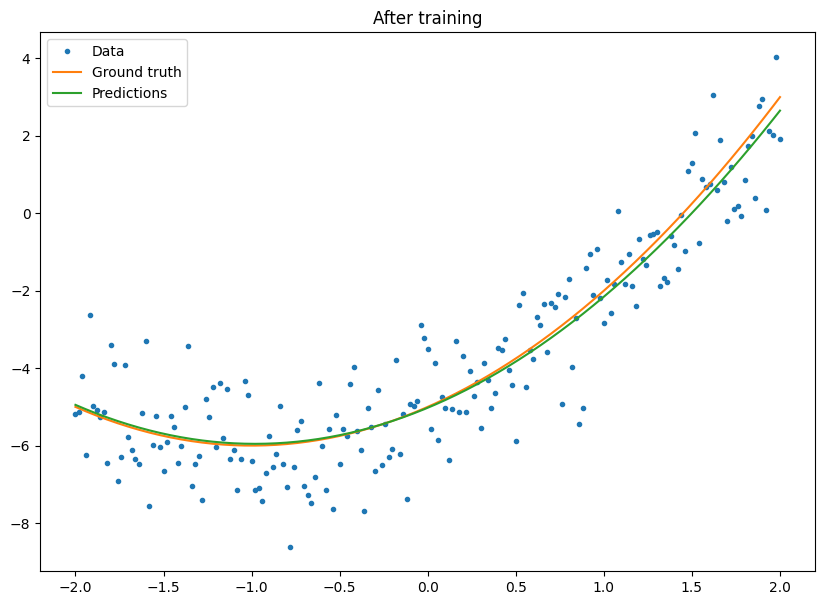

In [12]:
plot_preds(x, y, f, quad_model, 'After training')

In [13]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [14]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


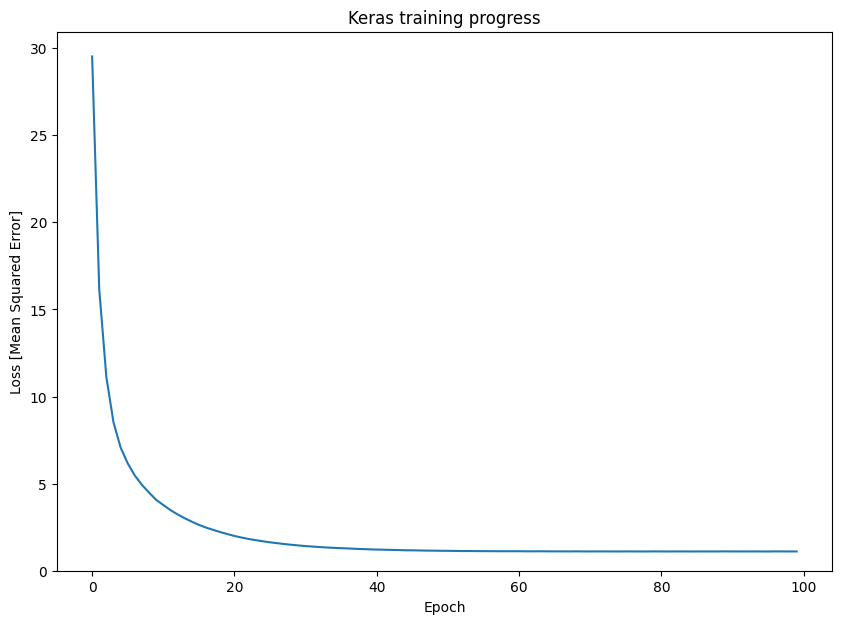

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

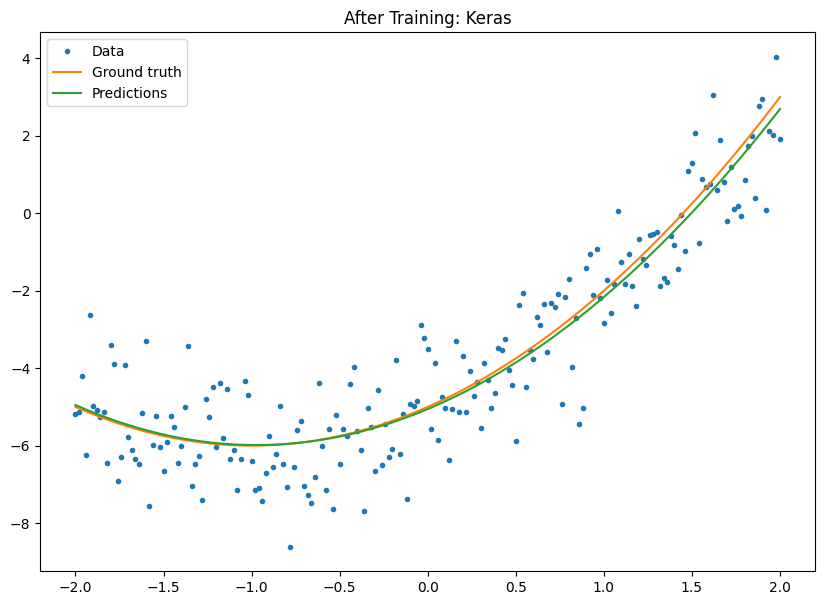

In [16]:
plot_preds(x, y, f, new_model, 'After Training: Keras')